<a href="https://colab.research.google.com/github/Heuzi/NN-kNN/blob/main/nnknn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#How to use this file

Run everything in "Module definitions" section. This will set up all the classes needed.

Run the section "pydml" to access knn using other distance metric learning algorithms.

Run a subsection in "Data Sets" section to load the data set you want.

If the data set is a regression data set, you may run "Standardize Regression Data sets". This may not be needed if your parameters are tuned.

Run either "classification" or "Regression".
Notice that at the beginning of these two sections, there are settings you can tune for NN-kNN

Run "Result look up" section to check results.

Good luck, future Ye or whoever reads this.

--- Past Ye

##Important settings for best performance

Regularizer like L2 REGULARIZATION WILL LOWER THE ACCURACY OF NNKNN!

default case activation layer's bias needs to be carefully set.

```
    # self.bias = torch.nn.Parameter(torch.ones(num_cases) * num_features/2 )
    self.bias = torch.nn.Parameter(torch.ones(num_cases) )
```
These two choices depends on the number of features you have. If you have too many features and the feature distances are big, they might reduce your case activation to 0 and therefore no learning can occur. In that case, use the first one.

Important note: you can tell if your model is trained properly. The model should at the very least, surpass k-nn. If you are having worse accuracy than a vanilla k-nn, then you will need to tune the parameters.


#Module definitions

Boring imports

In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch.optim as optim


##New Feature Act Layer

In [ ]:
dropout_rate = 0.5

In [ ]:
class Hidden_layers_1(nn.Module):
  def __init__(self,num_features, hidden_dim = None, extract_dim = None):
    if(hidden_dim == None):
      hidden_dim = num_features * 2
    if(extract_dim == None):
      extract_dim = num_features
    self.layer1 = nn.Linear(num_features, hidden_dim)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=dropout_rate)
    self.layer2 = nn.Linear(hidden_dim,extract_dim)
  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.layer2(x)
    x = self.relu(x)
    return x

In [ ]:
class FeatureActivationLayer(torch.nn.Module):
  '''
    measures the feature distance/activation between query and all cases
  '''
  def __init__(self, num_features, num_cases, cases, hidden_layers = None):
    super().__init__()
    #we assume feature weight sharing between segments
    self.feature_matrix = cases
    self.f1weight = torch.nn.Parameter(torch.ones(num_features))
    # self.activation_func = torch.relu

    self.hidden_layers = hidden_layers

  def forward(self, query, cases):
    '''
      input: (m+1) cases * n features; where the first case is the query
      output: m* n feature activations
    '''
    if self.hidden_layers != None:
      query = self.hidden_layers(query)
      cases = self.hidden_layers(cases)

    query = query.unsqueeze(1)

    #randomly select 10% of the rows of cases
    # cases = cases[torch.randperm(cases.shape[0])[:int(cases.shape[0] * 0.1)]]
    #lol
    # cases = nn.Dropout(p=0.99)(cases);

    # print("cool")
    # print(query.shape)
    # print(self.f1weight.shape)
    # print(cases.shape)
    # print(query)
    # print((query*self.f1weight).shape)
    # print((query*self.f1weight))
    # print(self.f1weight.shape)
    # print(self.f1weight)
    # print((cases*self.f1weight).shape)
    # print((cases*self.f1weight))
    # print((query*self.f1weight - cases*self.f1weight).shape)
    # print((query*self.f1weight - cases*self.f1weight))
    #the following utilize pytorch tensor broadcasting functionality
    #if the below line does not make sense, uncomment lines above to debug and check values
    return (query*self.f1weight - cases*self.f1weight)**2

###Old Feature Activation Layer
Deprecated

In [ ]:
class OldFeatureActivationLayer(torch.nn.Module):
  '''
    measures the feature distance/activation between query and all cases
  '''
  def __init__(self, num_features, num_cases, weight_sharing_within_segment=False, weight_sharing_between_segment= False, hidden_layers = False):
    super().__init__()
    self.weight_sharing_between_segment = weight_sharing_between_segment
    if self.weight_sharing_between_segment:
      self.segments = torch.nn.ModuleList([OldFeatureActivationSegment(num_features, weight_sharing_within_segment, hidden_layers)])
    else:
      self.segments = torch.nn.ModuleList([OldFeatureActivationSegment(num_features, weight_sharing_within_segment, hidden_layers) for _ in range(num_cases)])
    # feature activation layer should not have its own activation function,
    # instead, it should just reuse feature activation segments' activation function, which is called by OldFeatureActivationSegment
    # self.activation_func = torch.nn.Identity()
  def set_f_weight_for_all_segments(self, f):
    for segment in self.segments:
      segment.set_f1(f)
      segment.set_f2(f)
  def freeze_f_weight_for_all_segments(self):
    for segment in self.segments:
      segment.freeze_f1()
      segment.freeze_f2()
  def forward(self, query, cases):
    '''
      input: (m+1) cases * n features; where the first case is the query
      output: m* n feature activations
    '''
    if self.weight_sharing_between_segment:
      #only uses the first segment through out.
      return torch.stack([self.segments[0](query, case) for case in cases], dim=1)
    return torch.stack([segment(query, case) for segment, case in zip(self.segments, cases)], dim=1) ###OMG, colab is a great programmer.

###Old Feature Activation Segment

Deprecated

assume there are m cases, n features for each case

In [ ]:
class OldFeatureActivationSegment(torch.nn.Module):
  '''
    measures the feature distance/activation between two cases

    two features connect to one feature activation node

    multiple feature activation layer only connects to one case node

    num_features: number of features that f1 or f2 contains. f1 is a vector of features for one case.
  '''
  def __init__(self, num_features, weight_sharing=False, hidden_layers = False):
    super().__init__()
    self.weight_sharing = weight_sharing
    ## IMPORTANT DESIGN DECISION:: start weights and biases with ones instead of randoms.
    self.f1weight = torch.nn.Parameter(torch.ones(num_features))
    self.f2weight = torch.nn.Parameter(torch.ones(num_features))
    if weight_sharing:
      self.f2weight = self.f1weight
    #it does not make sense that the bias is non-zero.
    # self.bias = torch.nn.Parameter(torch.zeros(num_features))
    # self.activation_func = torch.nn.Identity()
    self.activation_func = torch.relu

    self.hidden_layers = hidden_layers
    hidden_dim = num_features * 2
    extract_dim = num_features
    self.layer1 = nn.Linear(num_features, hidden_dim)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(hidden_dim, extract_dim)

  # maybe not needed
  # def set_activation_func(self, activation_function):
  #   self.activation_func = activation_function

  def set_f1(self, f1):
    self.f1weight = f1

  def set_f2(self, f2):
    self.f2weight = f2

  def freeze_f1(self):
    self.f1weight.requires_grad = False

  def freeze_f2(self):
    self.f2weight.requires_grad = False

  def forward(self, f1, f2):
    '''
      input: f1 and f2, are both feature vectors of a case, shape n.
      output: feature activation, shape n.
    '''
    if self.hidden_layers:
      f1 = self.layer1(f1)
      f1 = self.relu(f1)
      f1 = self.layer2(f1)
      f1 = self.relu(f1)

      f2 = self.layer1(f2)
      f2 = self.relu(f2)
      f2 = self.layer2(f2)
      f2 = self.relu(f2)


    # return self.activation_func(self.f1weight * f1 + self.f2weight * f2 + self.bias)
    # IMPORTANT DESIGN DECISION:: minus makes more sense here as in standard k-NN.
    # feature_distance = self.f1weight * f1 - self.f2weight * f2
    # feature_distance = (self.f1weight * f1 - self.f2weight * f2) ** 2
    # feature_distance = torch.abs(self.f1weight * f1 - self.f2weight * f2)
    feature_distance = (self.f1weight * f1 - self.f2weight * f2) ** 2
    # feature_distance = torch.abs(self.f1weight * f1 - self.f2weight * f2)
    # return self.activation_func(feature_distance + self.bias)
    return self.activation_func(feature_distance)

##Case Activation Layer

IMPORTANT.
```
    # self.bias = torch.nn.Parameter(torch.ones(num_cases) * num_features/2 )
    self.bias = torch.nn.Parameter(torch.ones(num_cases) )
```
These two choices depends on the number of features you have. If you have too many features, may use the first one.


In [ ]:
class CaseActivationLayer(torch.nn.Module):
  '''
    measures the activation of a case given some feature activations

    input:
      m* n feature activations
    output:
      m case activations
  '''
  def __init__(self, num_features, num_cases, weight_sharing=False):
    super().__init__()
    self.weight_sharing = weight_sharing
    self.fa_weight = torch.nn.Parameter(torch.ones((num_cases, num_features)))
    if weight_sharing:
      self.fa_weight = torch.nn.Parameter(torch.ones(num_features))

    self.bias = torch.nn.Parameter(torch.ones(num_cases) * num_features/2 )
    # self.bias = torch.nn.Parameter(torch.ones(num_cases) )
    # self.bias = torch.nn.Parameter(torch.ones(num_cases) * num_features/10 )
  def forward(self,input):
    '''
      input: m*n feature activations
      output: m case activations
    '''
    input = - torch.sum(input * F.leaky_relu(self.fa_weight), dim=2) + self.bias
    ## we don't want negative values in activations
    ## they will mess up our top case selections because if the tops are negatives
    ## then the filled 0s are actually bigger.
    input = F.sigmoid(input)
    # input = torch.relu(input)
    return input

##Top Case Selection Layer

In [ ]:
# prompt: define a class named TopCaseLayer inherited from torch.nn.Module. This class is used to select the top k activations of an input tensor (m case activations), and output a tensor of the same shape but only keep the top k activations, and other tensors zeroed out

class TopCaseLayer(torch.nn.Module):
  def __init__(self, k):
    super().__init__()
    self.k = k
    self.training = True

  def forward(self, input):
    ##no behavior during training because we want to train for all.
    if self.training:
      return input
    '''
      input: m case activations
      output: m case activations, the top k activations are kept and others are zeroed out
    '''
    # print(input)
    vals, idx = torch.topk(input, self.k)

    #if any of the vals is zero, it will mess things up, reverse them so that they becomes positive.

    # print(input.shape)
    # print(idx.shape)
    # print(vals.shape)
    # print("huh??")
    output = torch.zeros_like(input).scatter_(1,idx, vals)
    #replace output values such that the top k is kept


    # output[:, idx] = vals
    return output


##Class Activation Layer

In [ ]:
# class ClassActivationLayer(torch.nn.Module):
#   '''
#     measures the activation of a class given some case activations

#     input:
#       m case_activations
#     output:
#       l class_activations
#   '''
#   def __init__(self, num_cases, case_labels, weight_sharing=False):
#     super().__init__()
#     self.constraints = []
#     self.case_labels = case_labels
#     self.num_classes = torch.unique(case_labels).shape[0]
#     # self.weight_sharing = weight_sharing
#     #weight sharing doesn't make sense here, some cases shouldn't contribute to a class while some should
#     # they should not share weights.
#     self.ca_weight = torch.nn.Parameter(torch.ones((num_cases, self.num_classes))) ## should I use randn here?
#     # self.ca_weight = torch.nn.Parameter(torch.rand((num_cases, self.num_classes)))
#     # if weight_sharing:
#     #   self.ca_weight = torch.nn.Parameter(torch.randn(num_cases))
#     # self.bias = torch.nn.Parameter(torch.randn(self.num_classes))
#     self.bias = torch.nn.Parameter(torch.zeros(self.num_classes))

#     print("self.ca_weight.shape", self.ca_weight.shape)
#   ##NOTE:: the following three constrain uses for loop, may not be the most efficient
#   def case_class_constrain_v1(self):
#     '''
#       ensures that each case only positively activates their correct class label.
#     '''
#     self.constraints.append("case_pos_class")


#   ##NOTE:: if used, this should be called before the constrain_v1()
#   def cases_share_weight_on_same_class(self):
#     '''
#       all cases of the same class share one weight for that class.
#     '''
#     self.constraints.append("case_share_weight_on_same_class")


#   def case_class_constrain_v2(self):
#     '''
#       ensures that each case does not contribute to incorrect classes.
#     '''
#     self.constraints.append("case_no_contribute_to_wrong_class")
#   def case_class_constrain_v3(self):
#     '''
#       ensures that each case only negatively contribute to incorrect classes.
#     '''
#     #TODO, needs revamping
#     #The weight manipulation should only happen during forward()
#     raise ValueError("error, needs revamping")
#     for i in range(self.ca_weight.shape[0]):
#       for j in range(self.ca_weight.shape[1]):
#         if j != case_labels[i]:
#           self.ca_weight[i][j] = 0 - torch.relu(self.ca_weight[i][j])
#   def forward(self, ca):
#     constrained_weight = self.ca_weight.clone().detach()
#     for i in range(constrained_weight.shape[0]):
#       for j in range(constrained_weight.shape[1]):
#         if(j == self.case_labels[i]):
#           if("case_pos_class" in self.constraints):
#             constrained_weight[i][j] = torch.relu(self.ca_weight[i][j])
#         else: # j != case_labels[i]
#           if("case_no_contribute_to_wrong_class" in self.constraints):
#             constrained_weight[i][j] = torch.zeros(1)
#     return torch.matmul(ca, constrained_weight) + self.bias #matrix multiplication will handle 1 dimension vector property

The below code is another implementation of ClassActivationLayer which use mask to reduce the amount of computations during the forward.

In [ ]:
class ClassActivationLayer(torch.nn.Module):
  '''
    measures the activation of a class given some case activations

    input:
      m case_activations
    output:
      l class_activations
  '''
  def __init__(self, num_cases, case_labels, weight_sharing=False):
    super().__init__()
    self.constraints = []
    self.case_labels = case_labels
    self.num_classes = torch.unique(case_labels).shape[0]
    # self.weight_sharing = weight_sharing
    #weight sharing doesn't make sense here, some cases shouldn't contribute to a class while some should
    # they should not share weights.
    self.ca_weight = torch.nn.Parameter(torch.ones((num_cases, self.num_classes))) ## should I use randn here?
    # self.ca_weight = torch.nn.Parameter(torch.rand((num_cases, self.num_classes)))
    # if weight_sharing:
    #   self.ca_weight = torch.nn.Parameter(torch.randn(num_cases))
    # self.bias = torch.nn.Parameter(torch.randn(self.num_classes))
    self.bias = torch.nn.Parameter(torch.ones(self.num_classes))

    # create a mask
    self.mask = torch.zeros_like(self.ca_weight)
    print("self.ca_weight.shape", self.ca_weight.shape)

  def update_mask(self):
    for i in range(self.mask.shape[0]):
      for j in range(self.mask.shape[1]):
        if(j == self.case_labels[i]):
          if("case_pos_class" in self.constraints):
            self.mask[i][j] = torch.ones(1)
        else: # j != case_labels[i]
          if("case_no_contribute_to_wrong_class" in self.constraints):
            self.mask[i][j] = torch.zeros(1)


  ##NOTE:: the following three constrain uses for loop, may not be the most efficient
  def case_class_constrain_v1(self):
    '''
      ensures that each case only positively activates their correct class label.
    '''
    self.constraints.append("case_pos_class")
    self.update_mask()


  ##NOTE:: if used, this should be called before the constrain_v1()
  def cases_share_weight_on_same_class(self):
    '''
      all cases of the same class share one weight for that class.
    '''
    self.constraints.append("case_share_weight_on_same_class")


  def case_class_constrain_v2(self):
    '''
      ensures that each case does not contribute to incorrect classes.
    '''
    self.constraints.append("case_no_contribute_to_wrong_class")
    self.update_mask()

  def case_class_constrain_v3(self):
    '''
      ensures that each case only negatively contribute to incorrect classes.
    '''
    #TODO, needs revamping
    #The weight manipulation should only happen during forward()
    raise ValueError("error, needs revamping")
    for i in range(self.ca_weight.shape[0]):
      for j in range(self.ca_weight.shape[1]):
        if j != case_labels[i]:
          self.ca_weight[i][j] = 0 - torch.relu(self.ca_weight[i][j])
  def get_constrained_weight(self):
    constrained_weight = self.mask * torch.relu(self.ca_weight)
    return constrained_weight;
  def forward(self, ca):
    constrained_weight = self.get_constrained_weight();
    return torch.matmul(ca, constrained_weight) + self.bias #matrix multiplication will handle 1 dimension vector property

##Regression Activation Layer

In [ ]:
class CustomSoftmaxLayer(torch.nn.Module):
  def __init__(self):
    super(CustomSoftmaxLayer, self).__init__()

  def forward(self, x):
    total = torch.sum(x, dim=1, keepdim=True)
    softmax_output = x / (total + 1e-10)

    ##IMPORTANT, cannot use the softmax version below, because of dividing by 0 problem.

    # # Apply the exponential function to the input tensor
    # exp_x = torch.exp(x)

    # # Apply a mask to set the output to 0 where the input is 0
    # mask = (x != 0).float()  # Create a binary mask (1 where x is not 0, 0 where x is 0)

    # # Apply the mask to the output
    # softmax_output = exp_x * mask

    # # Normalize the output by dividing by the sum along the same axis
    # softmax_output = softmax_output / softmax_output.sum(dim=1, keepdim=True)

    return softmax_output

In [ ]:
# prompt: Build a regression activation layer just like the class activation layer above, but for the purpose of regression now
## right now this is essentially a linear layer, but somehow it's a lot slower than a linear layer,
class RegressionActivation_1_Layer(torch.nn.Module):
  '''
    measures the activation of a class given some case activations

    input:
      m case_activations
    output:
      1 regression_activations
  '''
  def __init__(self, num_cases, case_labels, weight_sharing=False):
    super().__init__()
    self.constraints = []
    self.num_classes = 1
    self.case_labels = case_labels
    self.ca_weight = torch.nn.Parameter(torch.randn((num_cases, self.num_classes))) ## should I use randn here?
    self.bias = torch.nn.Parameter(torch.randn(self.num_classes))
    print("self.ca_weight.shape", self.ca_weight.shape)
  def forward(self, ca):
    ##IMPORTANT, newly added "* case_labels" here, so that case labels is now considered in
    ##the last layer of NN-k-NN regressor.
    # print("debugg msaafasdf")
    # print(ca.shape)
    # print(self.ca_weight.shape)
    # print(self.case_labels.shape)
    # print((torch.matmul(ca * self.case_labels, self.ca_weight)).shape)
    return torch.matmul(ca, self.ca_weight) + self.bias

In [ ]:
class RegressionActivation_2_Layer(torch.nn.Module):
  '''
    measures the activation of a class given some case activations

    input:
      m case_activations
    output:
      1 regression_activations
  '''
  def __init__(self, num_cases, case_labels, weight_sharing=False):
    super().__init__()
    self.constraints = []
    self.num_classes = 1
    self.case_labels = case_labels
    self.ca_weight = torch.nn.Parameter(torch.ones((num_cases, self.num_classes))) ## should I use randn here?
    self.bias = torch.nn.Parameter(torch.randn(self.num_classes))
    print("self.ca_weight.shape", self.ca_weight.shape)
  def forward(self, ca):
    return torch.matmul(ca* self.case_labels, self.ca_weight) + self.bias

In [ ]:
class RegressionActivation_3_Layer(torch.nn.Module):
  '''
    measures the activation of a class given some case activations

    input:
      m case_activations
    output:
      1 regression_activations
  '''
  def __init__(self, num_cases, case_labels, weight_sharing=False):
    super().__init__()
    self.constraints = []
    self.num_classes = 1
    self.case_labels = case_labels
  def forward(self, ca):
    return torch.matmul(ca, self.case_labels) #+ self.bias

In [ ]:
ca = torch.Tensor([1 , 0.5, 0.3])

In [ ]:
ca.shape

torch.Size([3])

In [ ]:
case_labels = torch.Tensor([0,2,2])

In [ ]:
torch.matmul(ca, case_labels)

tensor(1.6000)

In [ ]:
class RegressionActivation_4_Layer(torch.nn.Module):
  '''
    measures the activation of a class given some case activations

    input:
      m case_activations
    output:
      1 regression_activations
  '''
  def __init__(self, num_cases, case_labels, weight_sharing=False):
    super().__init__()
    self.constraints = []
    self.num_classes = 1
    self.case_labels = case_labels
    self.ca_weight = torch.nn.Parameter(torch.tensor(case_labels).reshape(num_cases, self.num_classes)) ## should I use randn here?
    self.bias = torch.nn.Parameter(torch.randn(self.num_classes))
    print("self.ca_weight.shape", self.ca_weight.shape)
  def forward(self, ca):
    ##IMPORTANT, newly added "* case_labels" here, so that case labels is now considered in
    ##the last layer of NN-k-NN regressor.
    # print("debugg msaafasdf")
    # print(ca.shape)
    # print(self.ca_weight.shape)
    # print(self.case_labels.shape)
    # print((torch.matmul(ca * self.case_labels, self.ca_weight)).shape)
    return torch.matmul(ca, self.ca_weight) + self.bias

In [ ]:
a = torch.ones((100, 8))
b = torch.ones((1548, 8))
c = torch.ones((1))

In [ ]:
# a-b

In [ ]:
# (b*b).shape

In [ ]:
# (a*b).shape

In [ ]:
# torch.matmul(a, b).shape

In [ ]:
# torch.matmul(a, b)

In [ ]:
# torch.matmul(a, b) + c

## NN-k-NN

In [ ]:
import torch.nn.functional as F


class NN_k_NN(torch.nn.Module):
  def __init__(self, cases, case_labels,
               fa_weight_sharing_within_segment,
               fa_weight_sharing_between_segment,
               ca_weight_sharing,
               top_case_enabled, top_k,
               class_weight_sharing, hidden_layers= None):
    super().__init__()
    self.cases = cases
    num_cases = cases.shape[0]

    num_features = cases.shape[1]
    if not (hidden_layers is None):
      num_features = hidden_layers(cases).shape[1]
    # num_classes = torch.unique(case_labels).shape[0] # len(set(case_labels))
    ##IMPORTANT:: CHECK THE WEIGHT_SHARING PARAMETERS!!
    # self.fa_layer = FeatureActivationLayer(num_features, num_cases,
    #                                        weight_sharing_within_segment= fa_weight_sharing_within_segment,
    #                                        weight_sharing_between_segment= fa_weight_sharing_between_segment,
    #                                        hidden_layers = hidden_layers)
    self.fa_layer = FeatureActivationLayer(num_features, num_cases, self.cases, hidden_layers = hidden_layers)

    self.ca_layer = CaseActivationLayer(num_features, num_cases,
                                        weight_sharing= ca_weight_sharing)
    self.top_case_enabled = top_case_enabled
    self.selection_layer = TopCaseLayer(top_k)
    self.class_layer = ClassActivationLayer(num_cases, case_labels,
                                            weight_sharing=class_weight_sharing)
    ## more preprocessing here needed to tie each case to their correct class
    ## only one is turned on right now for testing purpose.
    self.class_layer.case_class_constrain_v1()
    self.class_layer.case_class_constrain_v2()

    self.ca_dropout = torch.nn.Dropout(p=0.5)

  def forward(self, query):
    #repeat query so that it has the same shape as self.cases
    # query = query.repeat(self.cases.shape[0], 1)
    #no need to repeat the query, fa_layer's forward will handle it.
    feature_activations = self.fa_layer(query, self.cases)
    # print("feature_activations.shape", feature_activations.shape)
    ##tie the fa_segments with corresponding case in ca layer
    #each segment should only tie to one case in ca_layer
    case_activations = self.ca_layer(feature_activations)
    # print("case_activations" , case_activations.shape)
    #uncomment to enable topk
    if self.top_case_enabled:
      case_activations = self.selection_layer(case_activations)

    if self.training:
      ##  case_activations = self.ca_dropout(case_activations)
      ## print("dropout")
      ##==========#
      ## expect the case_activations has the shape of (query_number, case_numer)
      ## expect the query has the shape of (batch_size, feature_size)
      ## expect the cases has the shape of (case_number, feature_size)
      dquery = query.unsqueeze(1)
      dcases = self.cases.unsqueeze(0)
      difference = torch.sum(dquery - dcases, dim=-1)
      masks = torch.where(difference == 0, 0., 1.)
      case_activations = case_activations * masks


    # print("case_activations" , case_activations.shape)
    class_ativations = self.class_layer(case_activations)
    # print("class_ativations.shape", class_ativations.shape)

    # Softmax activation for classification
    # output = F.softmax(class_ativations, dim=1)
    output = class_ativations

    # Get the class predictions (class with the highest probability)
    ## TODO:: need debug here, am I using the right dim?
    _, predicted_class = torch.max(output, 1)

    return feature_activations, case_activations, output, predicted_class
    # return self.class_layer(ca)

##NN-k-NN regression

In [ ]:
import torch.nn.functional as F

##IMPORTANT, cannot use top case selection layer here like we do in for classification.
## it has to be either enabled or disabled the whole time.
class NN_k_NN_regression(torch.nn.Module):
  def __init__(self, cases, case_labels,
               fa_weight_sharing_within_segment,
               fa_weight_sharing_between_segment,
               ca_weight_sharing,
               top_case_enabled, top_k,
               class_weight_sharing, hidden_layers= None):
    super().__init__()
    self.cases = cases
    num_cases = cases.shape[0]
    num_features = cases.shape[1]
    # num_classes = torch.unique(case_labels).shape[0] # len(set(case_labels))
    ##IMPORTANT:: CHECK THE WEIGHT_SHARING PARAMETERS!!
    # self.fa_layer = FeatureActivationLayer(num_features, num_cases,
    #                                        weight_sharing_within_segment= fa_weight_sharing_within_segment,
    #                                        weight_sharing_between_segment= fa_weight_sharing_between_segment,
    #                                        hidden_layers = hidden_layers)
    self.fa_layer = FeatureActivationLayer(num_features, num_cases, self.cases, hidden_layers = hidden_layers)
    self.ca_layer = CaseActivationLayer(num_features, num_cases,
                                        weight_sharing= ca_weight_sharing)
    self.top_case_enabled = top_case_enabled
    self.selection_layer = TopCaseLayer(top_k)

    self.ca_dropout = torch.nn.Dropout(p=0.5)

    self.softmax = CustomSoftmaxLayer()
    # self.softmax = torch.nn.Softmax(dim=1)

    self.class_layer = RegressionActivation_3_Layer(num_cases, case_labels,weight_sharing=class_weight_sharing)
    # self.class_layer = torch.nn.Linear(num_cases, 1)


  def forward(self, query):
    feature_activations = self.fa_layer(query, self.cases)
    # print("feature_activations.shape", feature_activations.shape)
    ##tie the fa_segments with corresponding case in ca layer
    #each segment should only tie to one case in ca_layer
    case_activations = self.ca_layer(feature_activations)
    # print("case_activations" , case_activations.shape)
    #uncomment to enable topk
    if self.top_case_enabled:
      case_activations = self.selection_layer(case_activations)
    # print("case_activations1" , torch.sum(case_activations, dim= 1))

    if self.training:
      # case_activations = self.ca_dropout(case_activations)
      # print("dropout")
      # ==========#
      # expect the case_activations has the shape of (query_number, case_numer)
      # expect the query has the shape of (batch_size, feature_size)
      # expect the cases has the shape of (case_number, feature_size)
      dquery = query.unsqueeze(1)
      dcases = self.cases.unsqueeze(0)
      difference = torch.sum(dquery - dcases, dim=-1)
      masks = torch.where(difference == 0, 0., 1.)
      case_activations = case_activations * masks

    case_activations = self.softmax(case_activations)
    #get top k of case_activations
    values, indices = torch.topk(case_activations, k=self.selection_layer.k, dim=1)

    output = torch.mean(self.class_layer.case_labels[indices], dim=1)
    # print("case_activations" , torch.sum(case_activations, dim= 1))
    predicted_number = self.class_layer(case_activations)

    # # Softmax activation for classification
    # output = F.softmax(class_ativations, dim=1)
    # # output = class_ativations
    # _, predicted_class = torch.max(output, 1)
    # print("predicted_class", predicted_class)
    # predicted_class = case_labels[predicted_class]
    # print("predicted_class after label lookup", predicted_class)
    ##added feature activations here in output because they might be used for adaptation
    ####VERY VERY IMPORTANT, the output format is different!!
    return feature_activations, case_activations, output,  predicted_number


In [ ]:
# # prompt: a standard neural network with fully connected layers that has the same architecture as NN_k_NN_regression

# class nn_regression(torch.nn.Module):
#   def __init__(self, cases, case_labels,
#                fa_weight_sharing_within_segment,
#                fa_weight_sharing_between_segment,
#                ca_weight_sharing,
#                top_case_enabled, top_k,
#                class_weight_sharing):
#     super().__init__()
#     ##WIP
#     self.cases = torch.nn.parameters(torch.randn_like(cases))
#     num_cases = cases.shape[0]
#     num_features = cases.shape[1]
#     # num_classes = torch.unique(case_labels).shape[0] # len(set(case_labels))
#     ##IMPORTANT:: CHECK THE WEIGHT_SHARING PARAMETERS!!
#     self.fa_layer = FeatureActivationLayer(num_features, num_cases, weight_sharing_within_segment= fa_weight_sharing_within_segment,
#                                            weight_sharing_between_segment= fa_weight_sharing_between_segment)
#     self.ca_layer = CaseActivationLayer(num_features, num_cases,
#                                         weight_sharing= ca_weight_sharing)
#     self.top_case_enabled = top_case_enabled
#     self.selection_layer = TopCaseLayer(top_k)
#     self.class_layer = RegressionActivationLayer(num_cases,weight_sharing=class_weight_sharing)


#   def forward(self, query):
#     feature_activations = self.fa_layer(query, self.cases)
#     ##tie the fa_segments with corresponding case in ca layer
#     #each segment should only tie to one case in ca_layer
#     case_activations = self.ca_layer(feature_activations)

#     #uncomment to enable topk
#     if self.top_case_enabled:
#       case_activations = self.selection_layer(case_activations)

#     predicted_number = self.class_layer(case_activations)

#     # # Softmax activation for classification
#     # output = F.softmax(class_ativations, dim=1)
#     # # output = class_ativations
#     # _, predicted_class = torch.max(output, 1)
#     # print("predicted_class", predicted_class)
#     # predicted_class = case_labels[predicted_class]
#     # print("predicted_class after label lookup", predicted_class)
#     ##added feature activations here in output because they might be used for adaptation
#     return feature_activations, case_activations, predicted_number


In [ ]:
def print_model_features(input_model):
  for n, p in model.named_parameters():
    print(n)
    print(p.data)

In [ ]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)

#pydml

In [ ]:
pip install metric-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 1.8 MB/s eta 0:00:00


In [ ]:
import metric_learn

#Data Sets

##Classification, depression

From Zach Wilkerson, ICCBR challenge.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/2023 research/NN-kNN/Dataset_MO_ENG.csv")

In [ ]:
## eliminating physical-related questions
df = df.drop(df.columns[102:-1], axis=1)


## Creating classes 0-> Low risk, 1->Medium Risk, 2->High risk
dic = { 1: 0 , 2: 0, 3:1, 4:2, 5:2}
df['Target'] = df['Target'].map(dic)

train_cols = df.columns[0:-1]
label = df.columns[-1]
X = df[train_cols]
y = df[label]
target_names=["Low","Medium","High"]
df

,1. Most of the time I have difficulty concentrating on simple tasks,2. I don't feel like doing my daily duties,3. My friends or family have told me that I look different,4. When I think about the future it is difficult for me to imagine it clearly,5. People around me often ask me how I feel,6. I consider that my life is full of good things,7. My hobbies are still important to me,8. I'm still as punctual as I have always been,"9. If I had the chance, I would spend all day in my bed",10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular,...,94. I lose control easily,95. Neighbors must put up with each other's noises without complaining,96. Littering on public roads is wrong,97. People who commit crimes have their reasons for doing it,98. It is normal to change jobs several times a year,99. It is important to respect turns,100. I could pretend to be someone else to achieve what I want,101. I consider it important that all people have the same rights,"102. I have a hard time taking ""no"" for an answer",Target
0,1,1,0,1,0,1,1,1,0,0,...,1,1,0,0,1,0,1,0,1,0
1,1,0,1,1,0,1,1,1,0,0,...,0,1,0,0,1,0,1,1,0,0
2,0,0,0,0,1,1,1,0,0,1,...,0,1,0,0,1,0,1,0,1,1
3,0,0,0,1,0,1,1,1,1,0,...,0,1,0,1,1,0,1,0,1,2
4,1,1,0,1,0,1,0,1,1,1,...,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,1,1,1,0,0,1,1,1,0,1,...,0,1,1,1,1,1,1,0,1,2
100,1,1,0,0,1,1,1,0,0,0,...,0,1,0,1,1,0,0,0,0,1
101,0,0,1,1,1,1,1,0,1,1,...,0,1,0,0,1,1,1,1,1,0
102,1,0,0,0,1,1,1,1,1,1,...,0,1,1,0,1,0,1,1,0,2


In [ ]:
y.value_counts()

Target
0    39
1    35
2    30
Name: count, dtype: int64

In [ ]:
random_state = 13
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=random_state, k_neighbors=3)
X, y = oversample.fit_resample(X, y)

In [ ]:
y.value_counts()

Target
0    39
1    39
2    39
Name: count, dtype: int64

In [ ]:
# prompt: convert X and y into tensors

Xs = torch.tensor(X.values).float()
ys = torch.tensor(y.values).long()


##Regression, depression

From Zach Wilkerson, ICCBR challenge.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/2023 research/NN-kNN/Dataset_MO_ENG.csv")

In [ ]:
## eliminating physical-related questions
df = df.drop(df.columns[102:-1], axis=1)


## Creating classes 0-> Low risk, 1->Medium Risk, 2->High risk
# dic = { 1: 0 , 2: 0, 3:1, 4:2, 5:2}
# df['Target'] = df['Target'].map(dic)

train_cols = df.columns[0:-1]
label = df.columns[-1]
X = df[train_cols]
y = df[label]
target_names=["Low","Medium","High"]
df

,1. Most of the time I have difficulty concentrating on simple tasks,2. I don't feel like doing my daily duties,3. My friends or family have told me that I look different,4. When I think about the future it is difficult for me to imagine it clearly,5. People around me often ask me how I feel,6. I consider that my life is full of good things,7. My hobbies are still important to me,8. I'm still as punctual as I have always been,"9. If I had the chance, I would spend all day in my bed",10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular,...,94. I lose control easily,95. Neighbors must put up with each other's noises without complaining,96. Littering on public roads is wrong,97. People who commit crimes have their reasons for doing it,98. It is normal to change jobs several times a year,99. It is important to respect turns,100. I could pretend to be someone else to achieve what I want,101. I consider it important that all people have the same rights,"102. I have a hard time taking ""no"" for an answer",Target
0,1,1,0,1,0,1,1,1,0,0,...,1,1,0,0,1,0,1,0,1,2
1,1,0,1,1,0,1,1,1,0,0,...,0,1,0,0,1,0,1,1,0,2
2,0,0,0,0,1,1,1,0,0,1,...,0,1,0,0,1,0,1,0,1,3
3,0,0,0,1,0,1,1,1,1,0,...,0,1,0,1,1,0,1,0,1,5
4,1,1,0,1,0,1,0,1,1,1,...,0,1,0,0,1,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,1,1,1,0,0,1,1,1,0,1,...,0,1,1,1,1,1,1,0,1,5
100,1,1,0,0,1,1,1,0,0,0,...,0,1,0,1,1,0,0,0,0,3
101,0,0,1,1,1,1,1,0,1,1,...,0,1,0,0,1,1,1,1,1,2
102,1,0,0,0,1,1,1,1,1,1,...,0,1,1,0,1,0,1,1,0,4


In [ ]:
y.value_counts()

Target
2    35
3    35
4    22
5     8
1     4
Name: count, dtype: int64

In [ ]:
random_state = 13
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=random_state, k_neighbors=3)
X, y = oversample.fit_resample(X, y)

In [ ]:
y.value_counts()

Target
2    35
3    35
5    35
1    35
4    35
Name: count, dtype: int64

In [ ]:
# prompt: convert X and y into tensors

Xs = torch.tensor(X.values).float()
ys = torch.tensor(y.values).long()


In [ ]:
## only use this if you want to treat it as a regression problem.
ys = ys.float()

##Classification, CIFAR-10



NOTE:: Tried using the CIFAR-10. Too big to run.

###Prep data and conv extractor

Description of this data set can be found on https://www.cs.toronto.edu/~kriz/cifar.html

According to this page:

"Baseline results

You can find some baseline replicable results on this dataset on the project page for cuda-convnet. These results were obtained with a convolutional neural network. Briefly, they are 18% test error without data augmentation and 11% with. Additionally, Jasper Snoek has a new paper in which he used Bayesian hyperparameter optimization to find nice settings of the weight decay and other hyperparameters, which allowed him to obtain a test error rate of 15% (without data augmentation) using the architecture of the net that got 18%."

Code in this section is based on https://colab.research.google.com/drive/1js_1rFZist_-rfNwmVZbXj0m7hKyX7xn#scrollTo=IR1Do_wt14ZE

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

it is a pytorch tutorial named cifar10_tutorial.ipynb

In [ ]:
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# prompt: get trainset into Xs and ys as tensors

X_train, y_train = [], []
for x, y in trainloader:
  X_train.append(x)
  y_train.append(y)
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)

X_test, y_test = [], []
for x, y in testloader:
  X_test.append(x)
  y_test.append(y)
X_test = torch.cat(X_test, dim=0)
y_test = torch.cat(y_test, dim=0)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_test.shape

Let us show some of the training images, for fun.



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
class Conv_cifar10(nn.Module):
    def __init__(self):
        super(Conv_cifar10, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #QUESTION:: should we have fc layers here?
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


In [ ]:
def eval_cifar10(model):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct, total

###ConvNN baseline

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
best_accuracy = 0  # best test accuracy
patience_counter = 0
for epoch in range(1000):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    # evaluate on test set
    correct, total = eval_cifar10(net)
    best_accuracy = max(best_accuracy, correct / total)
    if best_accuracy == correct / total:
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter > 40:
        break

print('Finished Training')

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:

correct, total = eval_cifar10(net)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
def eval_by_class(model_to_test):
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          outputs = model_to_test(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(4):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1
  return class_correct, class_total

class_correct, class_total = eval_by_class(net)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

##Classification, Fashion MNIST

In [ ]:
# prompt: load fashion mnist data set into Xs and ys
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load training set and test set
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)



In [ ]:
trainset[0][0]

In [ ]:
trainset[0][1]

##Classification, data sets

In [ ]:
from re import X
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import fetch_olivetti_faces
# sklearn.datasets.fetch_olivetti_faces
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler




iris = load_breast_cancer()
Xs = iris['data']
ys = iris['target']
# names = iris['target_names']
# feature_names = iris['feature_names']

## fit Xs in a scaler transform, transform Xs into 0-1
# scaler = MinMaxScaler()
# Xs = scaler.fit_transform(Xs)
if Xs.shape[1] == 64: #for breast cancer
  scaler = MinMaxScaler()
  Xs = scaler.fit_transform(Xs)

Xs = torch.tensor(Xs, dtype=torch.float32)
ys = torch.tensor(ys)

In [ ]:
Xs.shape

torch.Size([569, 30])

In [ ]:
Xs[0]

tensor([1.7990e+01, 1.0380e+01, 1.2280e+02, 1.0010e+03, 1.1840e-01, 2.7760e-01,
        3.0010e-01, 1.4710e-01, 2.4190e-01, 7.8710e-02, 1.0950e+00, 9.0530e-01,
        8.5890e+00, 1.5340e+02, 6.3990e-03, 4.9040e-02, 5.3730e-02, 1.5870e-02,
        3.0030e-02, 6.1930e-03, 2.5380e+01, 1.7330e+01, 1.8460e+02, 2.0190e+03,
        1.6220e-01, 6.6560e-01, 7.1190e-01, 2.6540e-01, 4.6010e-01, 1.1890e-01])

In [ ]:
ys[0].dtype

torch.int64

## Sanity check: A normal neural network classifier.

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler


# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.1, random_state=42, stratify=ys)

# # Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# # Define the neural network architecture for classification
# class NeuralNet(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(NeuralNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         return x

# # Hyperparameters
# input_size = X_train.shape[1]
# hidden_size = 64
# num_classes = torch.unique(ys).shape[0]
# learning_rate = 0.001
# batch_size = 16
# epochs = 50

# # Create DataLoader for training
# train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# # Initialize the model, loss function, and optimizer
# model = NeuralNet(input_size, hidden_size, num_classes)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(epochs):
#     for i, (inputs, labels) in enumerate(train_loader):
#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if (i + 1) % 5 == 0:
#             print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item()}')

# # Testing the model
# model.eval()
# with torch.no_grad():
#     outputs = model(X_test_tensor)
#     _, predicted = torch.max(outputs, 1)
#     accuracy = torch.sum(predicted == y_test_tensor).item() / len(y_test_tensor)
#     print(f'Accuracy on the test set: {accuracy * 100:.2f}%')


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.1, random_state=42, stratify=ys)

# Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = X_train
y_train_tensor = y_train
X_test_tensor = X_test
y_test_tensor = y_test

# Define the neural network architecture for classification
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size // 4),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 4, hidden_size // 2),
            # nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 2, hidden_size // 2),
            # nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 2, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, num_classes)
            )
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0)

    def forward(self, x):
        return self.nn(x)

# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 1024
num_classes = torch.unique(ys).shape[0]
learning_rate = 1e-5
batch_size = 16
epochs = 2000

# Create DataLoader for training
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# Initialize the model, loss function, and optimizer
model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    total_loss = 0.0
    accuracy = 0.0
    total_num = 0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        batch_size = len(labels)
        total_num += batch_size
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        _, predicted = torch.max(outputs, 1)
        accuracy += torch.sum(predicted == labels).item()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # if (i + 1) % 5 == 0
    if epoch == 0 or (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1}, Loss: {total_loss/(i+1):.2f} Acc: {accuracy/total_num :.2f}")
    # Testing the model
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = torch.sum(predicted == y_test_tensor).item() / len(y_test_tensor)
        print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

Epoch: 1, Loss: 1.10 Acc: 0.31
Accuracy on the test set: 33.33%
Accuracy on the test set: 33.33%
Accuracy on the test set: 41.67%
Accuracy on the test set: 41.67%
Accuracy on the test set: 33.33%
Accuracy on the test set: 33.33%
Accuracy on the test set: 41.67%
Accuracy on the test set: 41.67%
Accuracy on the test set: 41.67%
Accuracy on the test set: 41.67%
Accuracy on the test set: 33.33%
Accuracy on the test set: 41.67%
Accuracy on the test set: 41.67%
Accuracy on the test set: 41.67%
Accuracy on the test set: 41.67%
Accuracy on the test set: 41.67%
Accuracy on the test set: 41.67%
Accuracy on the test set: 33.33%
Accuracy on the test set: 33.33%
Accuracy on the test set: 33.33%
Accuracy on the test set: 33.33%
Accuracy on the test set: 33.33%
Accuracy on the test set: 33.33%
Accuracy on the test set: 33.33%
Accuracy on the test set: 33.33%
Accuracy on the test set: 33.33%
Accuracy on the test set: 33.33%
Accuracy on the test set: 33.33%
Accuracy on the test set: 33.33%
Accuracy on 

##Classification, Zebra

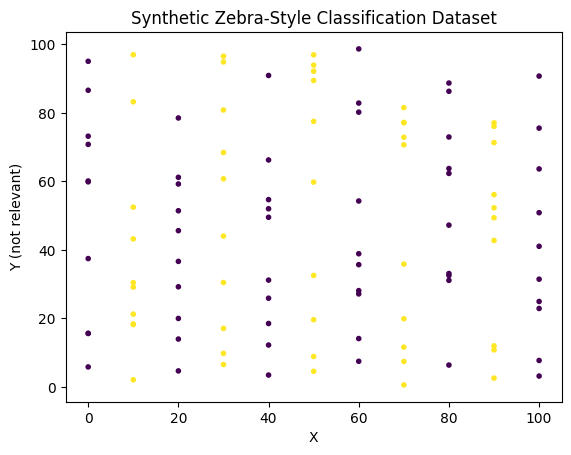

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Number of points per class
num_points = 110

# Generate alternating classes along the X-axis
x = np.linspace(0, 100, (int) (num_points/10))
#repeat X 10 times
x = np.repeat(x, 10)
y = np.random.rand(num_points)*100
labels = np.zeros(num_points)

# Assign alternating classes
labels[x%20 == 0] = 0
labels[x%20 != 0] = 1

# Plot the generated data
plt.scatter(x, y, c=labels, cmap='viridis', marker='.')
plt.title('Synthetic Zebra-Style Classification Dataset')
plt.xlabel('X')
plt.ylabel('Y (not relevant)')
# plt.colorbar(ticks=[0, 1], label='Class')
plt.show()


In [ ]:
Xs = torch.tensor(np.column_stack((x, y)), dtype=torch.float32)
ys = torch.tensor(labels, dtype=torch.long)

In [ ]:
Xs.shape

torch.Size([110, 2])

In [ ]:
ys[13]

tensor(1)

##Classification, Special Zebra

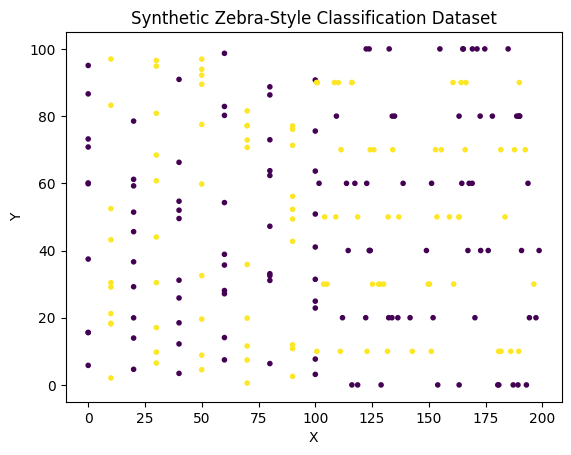

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Number of points per class
num_points = 110

# Generate alternating classes along the X-axis
x1 = np.linspace(0, 100, (int) (num_points/10))
#repeat X 10 times
x1 = np.repeat(x1, 10)
y1 = np.random.rand(num_points)*100
labels1 = np.zeros(num_points)

# Assign alternating classes
labels1[x1%20 == 0] = 0
labels1[x1%20 != 0] = 1

# Generate alternating classes along the X-axis
y2 = np.linspace(0, 100, (int) (num_points/10))
#repeat X 10 times
y2 = np.repeat(y2, 10)
x2 = 100 + np.random.rand(num_points)*100
labels2 = np.zeros(num_points)

# Assign alternating classes
labels2[y2%20 == 0] = 0
labels2[y2%20 != 0] = 1

x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))
labels = np.concatenate((labels1,labels2))


# Plot the generated data
plt.scatter(x, y, c=labels, cmap='viridis', marker='.')
plt.title('Synthetic Zebra-Style Classification Dataset')
plt.xlabel('X')
plt.ylabel('Y')
# plt.colorbar(ticks=[0, 1], label='Class')
plt.show()


In [ ]:
Xs = torch.tensor(np.column_stack((x, y)), dtype=torch.float32)
ys = torch.tensor(labels, dtype=torch.long)

##Classification, Breast Cancer Dataset

In [ ]:
# prompt: load_breast_cancer

cancer = load_breast_cancer()
Xs = cancer.data
ys = cancer.target
Xs = torch.tensor(Xs, dtype=torch.float32)
ys = torch.tensor(ys)

##Classification, BAL

Ziwei: Download the file below from https://archive.ics.uci.edu/dataset/12/balance+scale

In [ ]:
with open("balance-scale.data","r") as filef:
    bal_file = filef.readlines()

In [ ]:
Xs = []
ys = []
for line in bal_file:
    Xs.append([int(line[2]),int(line[4]),int(line[6]),int(line[8])])
    if line[0] == 'L':
        ys.append(0)
    elif line[0] == 'B':
        ys.append(1)
    elif line[0] == 'R':
        ys.append(2)

In [ ]:
Xs = torch.tensor(Xs).float()
ys = torch.tensor(ys)

##Regression, California Housing


In [ ]:
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing()
Xs = california_housing.data
ys = california_housing.target


In [ ]:
Xs[0]

array([   8.3252    ,   41.        ,    6.98412698,    1.02380952,
        322.        ,    2.55555556,   37.88      , -122.23      ])

In [ ]:
ys[0]

4.526

In [ ]:
ys[:100]

array([4.526  , 3.585  , 3.521  , 3.413  , 3.422  , 2.697  , 2.992  ,
       2.414  , 2.267  , 2.611  , 2.815  , 2.418  , 2.135  , 1.913  ,
       1.592  , 1.4    , 1.525  , 1.555  , 1.587  , 1.629  , 1.475  ,
       1.598  , 1.139  , 0.997  , 1.326  , 1.075  , 0.938  , 1.055  ,
       1.089  , 1.32   , 1.223  , 1.152  , 1.104  , 1.049  , 1.097  ,
       0.972  , 1.045  , 1.039  , 1.914  , 1.76   , 1.554  , 1.5    ,
       1.188  , 1.888  , 1.844  , 1.823  , 1.425  , 1.375  , 1.875  ,
       1.125  , 1.719  , 0.938  , 0.975  , 1.042  , 0.875  , 0.831  ,
       0.875  , 0.853  , 0.803  , 0.6    , 0.757  , 0.75   , 0.861  ,
       0.761  , 0.735  , 0.784  , 0.844  , 0.813  , 0.85   , 1.292  ,
       0.825  , 0.952  , 0.75   , 0.675  , 1.375  , 1.775  , 1.021  ,
       1.083  , 1.125  , 1.313  , 1.625  , 1.125  , 1.125  , 1.375  ,
       1.188  , 0.982  , 1.188  , 1.625  , 1.375  , 5.00001, 1.625  ,
       1.375  , 1.625  , 1.875  , 1.792  , 1.3    , 1.838  , 1.25   ,
       1.7    , 1.93

In [ ]:
# prompt: Convert Xs and ys to tensors for pytorch

Xs = torch.tensor(Xs, dtype=torch.float32)
ys = torch.tensor(ys, dtype=torch.float32)


In [ ]:
Xs.shape

torch.Size([20640, 8])

In [ ]:
# prompt: downsize the data set to 10%

from sklearn.model_selection import train_test_split
_, Xs, _, ys = train_test_split(Xs, ys, test_size=0.1, random_state=42)


In [ ]:
Xs.shape

torch.Size([2064, 8])

##Regression, Abalone

In [ ]:
import torch
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from urllib import request
from io import BytesIO
import zipfile

# Download the Abalone dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
response = request.urlopen(url)
abalone_data = response.read().decode("utf-8").splitlines()

# Process and convert the data to PyTorch tensors
data = [line.strip().split(',') for line in abalone_data]
X = []
y = []

# categories = ['M', 'F', 'I']
# label_encoder = OneHotEncoder(categories=[categories])
# label_encoder.fit(data)

def encode_sex(sex):
    if sex == 'M':
        return [1, 0, 0]
    elif sex == 'F':
        return [0, 1, 0]
    elif sex == 'I':
        return [0, 0, 1]

for row in data:
    # One-hot encode the 'Sex' feature
    # sex_encoded = label_encoder.transform([[row[0]]])[0]
    sex_encoded = encode_sex(row[0])

    # Convert the row to float and extract the target variable ('Rings')
    X.append(sex_encoded + list(map(float, row[1:-1])))
    y.append(float(row[-1]))

    # # Encode the categorical 'Sex' feature
    # row[0] = label_encoder.transform([row[0]])[0]
    # # Convert the row to float and extract the target variable ('Rings')
    # X.append(list(map(float, row[:-1])))
    # y.append(float(row[-1]))

Xs = torch.tensor(X, dtype=torch.float32)
ys = torch.tensor(y, dtype=torch.float32)


##Regression, Diabetes

In [ ]:
# prompt: load the diabetes dataset from sklearn

from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
Xs = diabetes.data
ys = diabetes.target
# prompt: convert Xs and ys to float tensor

Xs = torch.tensor(Xs, dtype=torch.float32)
ys = torch.tensor(ys, dtype=torch.float32)


In [ ]:
Xs[0]

tensor([ 0.0381,  0.0507,  0.0617,  0.0219, -0.0442, -0.0348, -0.0434, -0.0026,
         0.0199, -0.0176])

In [ ]:
torch.max(Xs,dim=0)

torch.return_types.max(
values=tensor([0.1107, 0.0507, 0.1706, 0.1320, 0.1539, 0.1988, 0.1812, 0.1852, 0.1336,
        0.1356]),
indices=tensor([204,   0, 367, 340, 230, 123,  58, 123,  23,  23]))

In [ ]:
ys[0]

tensor(151.)

In [ ]:
Xs.shape

torch.Size([442, 10])

In [ ]:
#

##Regression, Patchy classes

TODO

##Regression, Body Fat

Tried this data set on multiple settings. Our NN-kNN consistently perform poorly on this when compared to other methods.

https://www.kaggle.com/datasets/fedesoriano/body-fat-prediction-dataset?resource=download

https://www.kaggle.com/code/casper6290/bodyfat-prediction#1-|-Importing-Libraries-and-Loading-dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer
#
df = pd.read_csv("/content/drive/MyDrive/2023 research/NN-kNN/bodyfat.csv")
df.head()

In [ ]:
df.shape

In [ ]:
X = df.drop(['BodyFat','Density'],axis=1)
y = df['Density']

In [ ]:
X['Bmi']=703*X['Weight']/(X['Height']*X['Height'])
X.head()

In [ ]:
X['ACratio'] = X['Abdomen']/X['Chest']
X['HTratio'] = X['Hip']/X['Thigh']
X.drop(['Weight','Height','Abdomen','Chest','Hip','Thigh'],axis=1,inplace=True)
X.head()

In [ ]:
z = np.abs(stats.zscore(X))

#only keep rows in dataframe with all z-scores less than absolute value of 3
X_clean = X[(z<3).all(axis=1)]
y_clean = y[(z<3).all(axis=1)]
#find how many rows are left in the dataframe
X_clean.shape

In [ ]:
Xs = torch.tensor( X_clean.to_numpy(), dtype=torch.float32)
ys = torch.tensor( y_clean.to_numpy(), dtype=torch.float32)

In [ ]:
Xs[0]

In [ ]:
ys[0]

##Regression, Faces

In [ ]:
Xs = np.load("part_features.npy")
ys = np.load("part_targets.npy")
#These two files are in the nn-Knn folder.

In [ ]:
Xs = torch.tensor(Xs, dtype=torch.float32)
ys = torch.tensor(ys, dtype=torch.float32)


In [ ]:
from sklearn.model_selection import train_test_split
_, Xs, _, ys = train_test_split(Xs, ys, test_size=0.3, random_state=42)

##Sanity Check: A standard NN for regression

In [ ]:
# prompt: a standard neural network with 3 fully connected layers for regression

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class RegressionNet(nn.Module):
#   def __init__(self, input_size):
#     super().__init__()
#     self.fc1 = nn.Linear(input_size, 32)
#     self.fc2 = nn.Linear(32, 16)
#     self.fc3 = nn.Linear(16, 1)

#   def forward(self, x):
#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))
#     x = self.fc3(x)
#     return x


In [ ]:
# prompt: a standard neural network with 3 fully connected layers for regression

import torch
import torch.nn as nn
import torch.nn.functional as F

# class RegressionNet(nn.Module):
#   def __init__(self, input_size):
#     super().__init__()
#     self.fc1 = nn.Linear(input_size, 32)
#     self.fc2 = nn.Linear(32, 16)
#     self.fc3 = nn.Linear(16, 1)

#   def forward(self, x):
#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))
#     x = self.fc3(x)
#     return x

class RegressionNet(nn.Module):
    def __init__(self, input_size):
        super(RegressionNet, self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            # nn.Dropout(0.5),

            nn.Linear(32, 10),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(10, 1)

            # nn.Linear(32, 64),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.Linear(64, 128),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.Linear(128, 1)
            )
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0)

    def forward(self, x):
        return self.nn(x).squeeze()

In [ ]:
training_epochs = 3000
learning_rate = 1e-5
criterion = torch.nn.MSELoss()
batch_size = 10

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True
nn_cdh_enabled = False

best_model = None
patience = 40

# prompt: Train and test the RegressionNet on Xs and ys

k_fold = KFold(n_splits=10, shuffle = True,random_state = None)
accuracies = []

for train_index, test_index in k_fold.split(Xs):
  X_train, X_test = Xs[train_index], Xs[test_index]
  y_train, y_test = ys[train_index], ys[test_index]
  train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
  patience_counter = 0
  best_accuracy = None
  model = RegressionNet(Xs.shape[1])
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  for epoch in range(training_epochs):
    epoch_msg = True
    for X_train_batch, y_train_batch in train_loader:
      model.train()
      # Forward pass
      outputs = model(X_train_batch)
      loss = criterion(outputs, y_train_batch)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # if epoch_msg and (epoch + 1) % 100 == 0:
      #   epoch_msg = False
      #   print(f'Epoch [{epoch + 1}/{training_epochs}], Loss: {loss.item()}')

    # Testing the model
    model.eval()
    with torch.no_grad():
      outputs = model(X_test)
      loss = criterion(outputs, y_test)
      if best_accuracy is None or loss.item() < best_accuracy:
        best_accuracy = loss.item()
        best_model = model
        patience_counter = 0
      else:
        patience_counter += 1
      if epoch_msg and (epoch + 1) % 100 == 0:
        epoch_msg = False
        print(f'Epoch [{epoch + 1}/{training_epochs}], Test Loss: {loss.item()}')
        # print(f'Loss on the test set: {loss.item()}')
    if patience_counter >= patience:
      break
  accuracies.append(best_accuracy)
print(f'Average loss on the test set: {sum(accuracies)/len(accuracies)}')

Epoch [100/3000], Test Loss: 0.6423723101615906
Epoch [200/3000], Test Loss: 0.45588478446006775
Epoch [300/3000], Test Loss: 0.3575444519519806
Epoch [400/3000], Test Loss: 0.29476022720336914
Epoch [500/3000], Test Loss: 0.25905001163482666
Epoch [600/3000], Test Loss: 0.23944370448589325
Epoch [700/3000], Test Loss: 0.23291081190109253
Epoch [100/3000], Test Loss: 0.3844171166419983
Epoch [100/3000], Test Loss: 0.6953907608985901
Epoch [200/3000], Test Loss: 0.5814568400382996
Epoch [300/3000], Test Loss: 0.5507189631462097
Epoch [100/3000], Test Loss: 0.9911725521087646
Epoch [200/3000], Test Loss: 0.8221722841262817
Epoch [300/3000], Test Loss: 0.6419295072555542
Epoch [400/3000], Test Loss: 0.5331980586051941
Epoch [500/3000], Test Loss: 0.4931984543800354
Epoch [600/3000], Test Loss: 0.4732033312320709
Epoch [700/3000], Test Loss: 0.4568718373775482
Epoch [800/3000], Test Loss: 0.4418834447860718
Epoch [900/3000], Test Loss: 0.430118203163147
Epoch [1000/3000], Test Loss: 0.4196

For the vanilla neural network

```
Average loss on the test set: 1.3484851598739624

```

In [ ]:
accuracies

[0.23242825269699097,
 0.3771035969257355,
 0.5493008494377136,
 0.4118078947067261,
 0.2786405086517334,
 0.15259669721126556,
 0.8715450763702393,
 0.30623748898506165,
 0.4340432286262512,
 0.3482416868209839]

In [ ]:
np.mean(accuracies)

0.3961945280432701

In [ ]:
# prompt: print the number of parameters in model

print(sum(p.numel() for p in model.parameters()))


3637


#Test

##Classification

newly added here.

In [ ]:
# prompt: center and scale to normalize my Xs and ys

# def standardize_tensor(input_tensor):
#     mean = input_tensor.mean()
#     std = input_tensor.std()
#     standardized_tensor = (input_tensor - mean) / std
#     return standardized_tensor

# Xs = standardize_tensor(Xs)

In [ ]:
training_epochs = 1000
learning_rate = 0.01 #0.0001
criterion = torch.nn.CrossEntropyLoss()
batch_size = 100 #4 #100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = True
hidden_layers = None #Conv_cifar10() #None

top_k = 5
class_weight_sharing = True

patience = 40

In [ ]:
def trainModels(X_train,y_train):
  # https://contrib.scikit-learn.org/metric-learn/supervised.html#lmnn
  # lmnn = LMNN(n_neighbors=5, learn_rate=1e-6)
  # ##TODO, change here if you need to use a different one
  # # lmnn = metric_learn.MLKR()
  # # lmnn = metric_learn.NCA(max_iter=1000)
  # lmnn.fit(X_train,y_train)
  # knn = KNeighborsClassifier(n_neighbors=5,metric=lmnn.get_metric())
  # knn.fit(X_train,y_train)
  # # klmnn_accuracies.append( accuracy_score(knn.predict(X_test), y_test))
  # klmnn_acc = accuracy_score(knn.predict(X_test), y_test)
  klmnn_acc = 0
  # print("lmnn experiment done")
  # continue

  train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

  # Train model
  model = NN_k_NN(X_train, y_train,
               fa_weight_sharing_within_segment,
               fa_weight_sharing_between_segment,
               ca_weight_sharing,
               top_case_enabled, top_k,
               class_weight_sharing,hidden_layers)
  # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #, weight_decay=1e-5)
  # print_model_features(model)
  #Training loop
  # temp = []
  patience_counter = 0
  for epoch in range(training_epochs):
    epoch_msg = True
    # model.eval()
    # break
    for X_train_batch, y_train_batch in train_loader:
      model.train()
      feature_activations, case_activations, output, predicted_class = model(X_train_batch)
      loss = criterion(output, y_train_batch)
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if epoch_msg and (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch + 1}/{training_epochs}], Loss: {loss.item()}')
        #inspecting the case activations
        # top_case_indices = torch.topk(case_activations, 5, dim=1)[1]
        # print(top_case_indices)
        epoch_msg = False
      # print("evaluating")
    model.eval()
    with torch.no_grad():
      feature_activations, case_activations, output, predicted_class = model(X_test)
      # inspecting the case activations
      # top_case_indices = torch.topk(case_activations, 5, dim=1)[1]
      # print(top_case_indices)

      # Calculate accuracy
      accuracy_temp = accuracy_score(y_test, predicted_class)
    if epoch == 0:
      best_accuracy = accuracy_temp
      torch.save(model.state_dict(), PATH)
    elif accuracy_temp > best_accuracy:
      #memorize best model
      torch.save(model.state_dict(), PATH)
      best_accuracy = accuracy_temp
      patience_counter = 0
    elif patience_counter > patience:
      model = NN_k_NN(X_train, y_train,
               fa_weight_sharing_within_segment,
               fa_weight_sharing_between_segment,
               ca_weight_sharing,
               top_case_enabled, top_k,
               class_weight_sharing)
      model.load_state_dict(torch.load(PATH))
      model.eval()
      print("patience exceeded, loading best model")
      break
    else:
      patience_counter += 1

  # best_accuracies.append(best_accuracy)

  # print_model_features(model)
  # Test model
  with torch.no_grad():
    feature_activations, case_activations, output, predicted_class = model(X_test)

    #inspecting the case activations
    top_case_indices = torch.topk(case_activations, 5, dim=1)[1]
    # print(top_case_indices)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predicted_class)
    # Add accuracy to list
    # accuracies.append(accuracy)

  ##compare with a normal k-nn
  knn =  KNeighborsClassifier(n_neighbors=top_k)
  knn.fit(X_train, y_train)
  knn_acc  = accuracy_score(knn.predict(X_test), y_test)
  # knn_accuracies.append( accuracy_score(knn.predict(X_test), y_test))
  return klmnn_acc, best_accuracy, knn_acc, model

In [ ]:
# prompt: train and test my model on the Xs and ys in a 10 fold cross validation
from sklearn.neighbors import KNeighborsClassifier
from metric_learn import LMNN,NCA

from sklearn.metrics import accuracy_score
# Split data into 10 folds
k_fold = KFold(n_splits=10, shuffle = True,random_state = None)
# Scale data, not enabled right now.
# scaler = StandardScaler()
# scaler.fit(Xs)
# Xs = scaler.transform(Xs)

# Train and test model on each fold
best_model = None
model = None
PATH = 'best_classifier_model.h5'
best_accuracy = None
best_accuracies = []
accuracies = []
knn_accuracies = []

nca_accuracies = []
klmnn_accuracies = []

count = 0



In [ ]:
# X_train, X_test = Xs[train_index], Xs[test_index]
# y_train, y_test = ys[train_index], ys[test_index]

# klmnn_acc, best_accuracy, knn_acc, model = trainModels(X_train,y_train)
# accuracies.append(best_accuracy)
# knn_accuracies.append(knn_acc)
# klmnn_accuracies.append(klmnn_acc)


In [ ]:
for train_index, test_index in k_fold.split(Xs):
  # Get training and testing data
  X_train, X_test = Xs[train_index], Xs[test_index]
  y_train, y_test = ys[train_index], ys[test_index]
  klmnn_acc, best_accuracy, knn_acc, model = trainModels(X_train,y_train)
  accuracies.append(best_accuracy)
  knn_accuracies.append(knn_acc)
  klmnn_accuracies.append(klmnn_acc)

  #added for case maintenance experiment. comment it out if needed
  # break;

  # count += 1
  # if count == 2:
  #   break



self.ca_weight.shape torch.Size([512, 2])
Epoch [2/1000], Loss: 0.6835060119628906
Epoch [4/1000], Loss: 0.6549917459487915
Epoch [6/1000], Loss: 0.6732542514801025
Epoch [8/1000], Loss: 0.6484996676445007
Epoch [10/1000], Loss: 0.6589815020561218
Epoch [12/1000], Loss: 0.6907955408096313
Epoch [14/1000], Loss: 0.650188148021698
Epoch [16/1000], Loss: 0.5293143391609192
Epoch [18/1000], Loss: 0.37050861120224
Epoch [20/1000], Loss: 0.3491923213005066
Epoch [22/1000], Loss: 0.21838915348052979
Epoch [24/1000], Loss: 0.17247681319713593
Epoch [26/1000], Loss: 0.13314658403396606
Epoch [28/1000], Loss: 0.18764671683311462
Epoch [30/1000], Loss: 0.133039191365242
Epoch [32/1000], Loss: 0.15448327362537384
Epoch [34/1000], Loss: 0.06965664029121399
Epoch [36/1000], Loss: 0.06796222925186157
Epoch [38/1000], Loss: 0.09050679206848145
Epoch [40/1000], Loss: 0.05250363051891327
Epoch [42/1000], Loss: 0.05987957492470741
Epoch [44/1000], Loss: 0.044495973736047745
Epoch [46/1000], Loss: 0.02315

In [ ]:
# Print average accuracy
print("Average accuracy:", np.mean(accuracies))
print(np.mean(klmnn_accuracies))
print(np.mean(knn_accuracies))

Average accuracy: 0.9683270676691729
0.0
0.4128446115288221


## Classification with train test loader

TODO

##Standardize Regression Data sets

In [ ]:
# prompt: center and scale to normalize my Xs and ys

def standardize_tensor(input_tensor):
    mean = input_tensor.mean()
    std = input_tensor.std()
    standardized_tensor = (input_tensor - mean) / std
    return standardized_tensor

Xs = standardize_tensor(Xs)
ys = standardize_tensor(ys)

##Regression

In [ ]:
training_epochs = 1500
learning_rate = 0.01 #0.0001 #0.01
criterion = torch.nn.MSELoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = False
hidden_layers = None
top_k = 5
class_weight_sharing = True
nn_cdh_enabled = False

patience = 40

This code below will attempt to use TPU

In [ ]:
# import os
# assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'
# !pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl
# # imports pytorch
# import torch

# # imports the torch_xla package
# import torch_xla
# import torch_xla.core.xla_model as xm

# dev = xm.xla_device()
# Xs = Xs.to(dev)
# ys = ys.to(dev)


In [ ]:
# prompt: train and test my model on the Xs and ys in a 10 fold cross validation
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Split data into 10 folds
k_fold = KFold(n_splits=10, shuffle = True,random_state = None)
# Scale data, not enabled right now.
# scaler = StandardScaler()
# scaler.fit(Xs)
# Xs = scaler.transform(Xs)

# Train and test model on each fold
best_model = None
PATH = 'best_regressor_model.h5'
best_accuracy = None
best_accuracies = []
accuracies = []
top_k_average_accuracies = []
knn_accuracies = []
count = 0
for train_index, test_index in k_fold.split(Xs):
  # Get training and testing data
  X_train, X_test = Xs[train_index], Xs[test_index]
  y_train, y_test = ys[train_index], ys[test_index]

  # lmnn = metric_learn.MLKR()
  # lmnn.fit(X_train,y_train)
  # knn = KNeighborsRegressor(n_neighbors=5,metric=lmnn.get_metric())
  # knn.fit(X_train,y_train)
  # knn_accuracies.append( accuracy_score(knn.predict(X_test), y_test))

  # continue

  #build a train loader with my X_train and X_test
  train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

  # Train model
  model = NN_k_NN_regression(X_train, y_train,
               fa_weight_sharing_within_segment,
               fa_weight_sharing_between_segment,
               ca_weight_sharing,
               top_case_enabled, top_k,
               class_weight_sharing,
                             hidden_layers)
  # model = model.to(dev)
  # print("number of parameters in model: ",len(list(model.parameters())))
  # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #, weight_decay=1e-5)
  # print_model_features(model)
  #Training loop
  patience_counter = 0
  for epoch in range(training_epochs):
    # break # no training
    epoch_msg = True
    for X_train_batch, y_train_batch in train_loader:
      # print("training")
      ##DO NOT USE train() or eval() mode for regression
      ##top k selection will mess up the final layer output
      ##unlike in classification, each case's output is meaningful
      ##here in regresion, the collective output is meaningful.
      ## So if you topK case selection needs to be enabled or disabled the whole time.
      model.train()
      feature_activations, case_activations, output, predicted_number = model(X_train_batch)
      # break
      loss = criterion(predicted_number.squeeze(), y_train_batch)
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if epoch_msg and (epoch + 1) % 2 == 0:
        epoch_msg = False
        print(f'Epoch [{epoch + 1}/{training_epochs}], Loss: {loss.item()}')
        #inspecting the case activations
        # top_case_indices = torch.topk(case_activations, 5, dim=1)[1]
        # print(top_case_indices)
    # print("evaluating")
    # break

    model.eval()
    with torch.no_grad():
      feature_activations, case_activations, output, predicted_number = model(X_test)

    # inspecting the case activations
    # top_case_indices = torch.topk(case_activations, 5, dim=1)[1]
    # print(top_case_indices)

    # Calculate accuracy
    # accuracy_temp = mean_squared_error(y_test, predicted_number.squeeze().detach())
    accuracy_temp = criterion(y_test, predicted_number.squeeze().detach())
    if epoch == 0:
      best_accuracy = accuracy_temp
      torch.save(model.state_dict(), PATH)
    elif accuracy_temp < best_accuracy:
      #memorize best model
      torch.save(model.state_dict(), PATH)

      best_accuracy = accuracy_temp
      patience_counter = 0
    elif patience_counter > patience:
      model = NN_k_NN_regression(X_train, y_train,
               fa_weight_sharing_within_segment,
               fa_weight_sharing_between_segment,
               ca_weight_sharing,
               top_case_enabled, top_k,
               class_weight_sharing)
      model.load_state_dict(torch.load(PATH))
      model.eval()
      print("patience exceeded, loading best model")
      break
    else:
      patience_counter += 1
    # temp.append(accuracy_temp)
    # if len(temp) > patience and accuracy_temp > min(temp[-patience:]):
    #   ##patience runs out
    #   break
  # best_accuracies.append(min(temp))
  best_accuracies.append(best_accuracy)

  # print("testing")
  # print_model_features(model)
  # Test model
  feature_activations, case_activations, output, predicted_number = model(X_test)

  #inspecting the case activations
  top_case_indices = torch.topk(case_activations, 5, dim=1)[1]
  # print(top_case_indices)

  # Using top case solution as final solution
  # Calculate accuracy
  # accuracy = mean_squared_error(y_test, predicted_number)
  accuracy = criterion(y_test, predicted_number.squeeze())
  # Add accuracy to list
  accuracies.append(accuracy)

  top_k_average_accuracies.append(mean_squared_error(torch.mean(y_train[top_case_indices], dim=1),
                                                     y_test))

  ##compare with a normal k-nn
  knn =  KNeighborsRegressor(n_neighbors=top_k)
  knn.fit(X_train, y_train)
  knn_accuracies.append( mean_squared_error(knn.predict(X_test), y_test))

  # break
  # count += 1
  # if count == 5:
  #   break

# Print average accuracy
# print("Average accuracy:", np.mean(accuracies.detach().numpy()))
print("Average accuracy:", np.mean([acc.detach().numpy() for acc in accuracies]))

# print("Average top_k_average_accuracies", np.mean(top_k_average_accuracies))
print("Average top_k_average_accuracies", np.mean(top_k_average_accuracies))
# torch.cat(torch.mean(top_k_average_accuracies)).item())

Epoch [2/1500], Loss: 0.5380368828773499
Epoch [4/1500], Loss: 0.6111276149749756
Epoch [6/1500], Loss: 0.46001067757606506
Epoch [8/1500], Loss: 0.41264796257019043
Epoch [10/1500], Loss: 0.45030689239501953
Epoch [12/1500], Loss: 0.5843074321746826
Epoch [14/1500], Loss: 0.4940412938594818
Epoch [16/1500], Loss: 0.2602710425853729
Epoch [18/1500], Loss: 0.4859312176704407
Epoch [20/1500], Loss: 0.4066120982170105
Epoch [22/1500], Loss: 0.6090803742408752
Epoch [24/1500], Loss: 0.40855926275253296
Epoch [26/1500], Loss: 0.2712518572807312
Epoch [28/1500], Loss: 0.3194822371006012
Epoch [30/1500], Loss: 0.38951370120048523
Epoch [32/1500], Loss: 0.393422931432724
Epoch [34/1500], Loss: 0.423280268907547
Epoch [36/1500], Loss: 0.3997667729854584
Epoch [38/1500], Loss: 0.48717761039733887
Epoch [40/1500], Loss: 0.4000498056411743
Epoch [42/1500], Loss: 0.4061751961708069
Epoch [44/1500], Loss: 0.3863859176635742
Epoch [46/1500], Loss: 0.36606475710868835
Epoch [48/1500], Loss: 0.30123785

In [ ]:
print(np.mean(knn_accuracies))

0.4803648


In [ ]:
X_train[0].size()

torch.Size([10])

In [ ]:
# top_k_average_accuracies.append(mean_squared_error(torch.mean(y_train[top_case_indices], dim=1),
#                                                      y_test))

In [ ]:
predicted_number.device

device(type='cpu')

In [ ]:
predicted_number

tensor([-0.9792, -0.4128, -0.5223,  0.6196,  0.0159,  0.1886,  0.1584,  0.7702,
         0.5717,  0.8601,  0.5000, -0.0822,  0.0110,  1.3116,  1.2979,  0.5427,
         0.1696,  0.8904, -0.7151, -0.6171,  0.6625, -1.3483,  0.1151, -1.4584,
        -0.4694,  1.7975,  1.1913,  1.1509,  1.2303,  0.1610,  0.9336,  0.3741,
         0.4592,  0.3835,  1.6024,  1.2535,  0.2925,  0.4133,  0.5119, -0.7664,
         1.0422,  1.0946,  1.6598,  0.3048,  1.2885, -0.1864, -0.2541, -0.2693,
        -0.3201, -0.6668,  0.8749,  0.5075,  0.4138, -0.3991, -0.3158, -0.3661,
        -0.5243, -1.7325, -0.1869, -0.6002, -0.6069, -0.1109,  0.0723,  0.2147,
         0.7042, -1.8926,  1.1591,  1.8327, -0.1121,  0.0377,  0.6198,  1.1728,
         1.3388,  1.6657,  0.8525,  0.8914,  0.8506, -0.3312, -0.0271,  1.6513,
        -0.5845,  0.2124,  0.5536, -0.3095, -0.0584,  1.2706,  0.2393,  0.5529,
        -1.5109, -1.1205, -0.9736, -1.0065, -0.9713, -0.8817, -0.9582, -0.7773,
        -0.6953, -0.1028,  0.1769, -0.16

In [ ]:
model.cases.device

device(type='cpu')

In [ ]:
X_test.device

device(type='cpu')

In [ ]:
best_accuracies

[tensor(0.4020),
 tensor(0.3928),
 tensor(0.4481),
 tensor(0.3528),
 tensor(0.4417),
 tensor(0.4436),
 tensor(0.4102),
 tensor(0.4863),
 tensor(0.4740),
 tensor(0.4183)]

In [ ]:
top_k_average_accuracies

[0.9802677,
 0.8038256,
 0.7498629,
 0.8159676,
 1.308656,
 0.9834068,
 0.630725,
 0.7439191,
 0.83556765,
 0.67725897]

In [ ]:
# print("Average top_k_average_accuracies", torch.stack(torch.mean(top_k_average_accuracies)).item())
print("Average top_k_average_accuracies", np.mean(top_k_average_accuracies))


Average top_k_average_accuracies 0.8529457


In [ ]:
tens_1 = torch.Tensor([[10, 20], [30, 40]])
tens_2 = torch.Tensor([[2], [4]])

In [ ]:
tens_1 * tens_2

tensor([[ 20.,  40.],
        [120., 160.]])

In [ ]:
torch.mul(tens_1, tens_2)

tensor([[ 20.,  40.],
        [120., 160.]])

In [ ]:
torch.matmul(tens_1, tens_2)

tensor([[100.],
        [220.]])

In [ ]:
torch.sum(tens_1 * tens_2, dim=1)

tensor([ 60., 280.])

In [ ]:
knn.predict(X_test)

array([-1.0959984 , -0.28958914, -0.6617781 ,  0.76494616, -0.16552618,
        0.39275724,  0.39275724,  1.0751035 ,  0.45478868,  1.3232296 ,
        0.39275718,  0.14463127, -0.16552617,  1.3852609 ,  0.8890091 ,
        1.509324  , -0.16552615,  0.5168202 , -0.4756836 , -0.909904  ,
        1.3852612 , -1.2820928 ,  0.39275718, -1.5302188 , -0.41365212,
        1.7574499 ,  1.1991665 ,  0.45478874,  1.261198  ,  0.33072573,
        1.5713555 ,  0.39275724,  0.33072573,  0.08259977,  1.137135  ,
        1.5713555 ,  0.14463127, -0.04146319, -0.10349468, -0.97193545,
        0.39275724,  1.0751036 ,  1.0130721 , -0.04146319,  1.3232296 ,
       -0.0414632 , -0.5377151 , -0.16552618, -0.41365212, -0.5997466 ,
        0.39275724,  0.64088315,  0.70291466,  0.20666274, -0.3516206 ,
       -0.41365212, -0.22755766, -1.6542819 , -0.4756836 , -0.16552617,
       -0.3516206 , -0.4756836 ,  0.26869422,  0.08259979,  0.08259977,
       -1.9024079 ,  1.3232296 ,  1.8194813 , -0.10349467,  0.45

In [ ]:
y_test

tensor([-0.9099, -0.9099,  0.3307,  1.5714,  0.3307, -0.9099,  0.9510, -0.2896,
         0.0206, -0.2896,  0.6409, -0.2896,  0.0206,  0.0206,  0.9510, -0.9099,
         0.3307,  0.9510, -0.2896,  0.0206,  1.5714, -1.5302,  0.3307, -1.8404,
         0.3307,  3.1221,  0.0206,  0.6409,  0.9510,  1.2612,  2.5018,  3.1221,
         1.8815,  1.2612,  3.1221,  2.8120,  1.8815,  2.1917,  1.5714,  0.0206,
         0.9510,  2.1917,  3.4323,  1.5714,  2.1917, -0.2896,  0.0206,  0.3307,
         0.9510, -0.2896,  0.9510,  0.3307,  0.0206,  0.3307,  0.9510,  0.9510,
         0.6409, -1.8404,  2.5018,  0.0206, -0.9099, -0.2896,  0.0206,  2.8120,
         0.3307, -2.1505,  0.9510,  1.5714,  0.6409,  1.5714,  0.6409,  2.1917,
         0.9510,  1.5714,  1.2612,  2.1917,  0.6409,  0.0206, -0.9099,  1.5714,
        -0.5997, -0.5997,  0.0206,  0.0206, -1.2201,  1.2612, -0.2896,  0.6409,
        -1.2201, -1.5302, -1.2201, -0.9099, -0.9099, -1.2201, -1.2201, -0.9099,
        -0.9099, -0.9099,  0.0206, -0.59

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(knn.predict(X_test), y_test)


In [ ]:
mse

0.5110886

In [ ]:
model.class_layer

RegressionActivation_3_Layer()

In [ ]:
# model.class_layer.weight.shape

In [ ]:
# model.class_layer

In [ ]:
print(sum(p.numel() for p in model.parameters()))

3780


#Case Base Maintenance

The case base maintenance procedure will be different from classification and regression, because as of now, the regression activation layer, is not assigning weights. Instead it is using case activation as a direction indication of the case's weight, and taking a weighted average of case activation* case label to predict the final label.

Classification's class activation layer is easier, where we do assign each case with weights for every classes.

##Classification

Parameters here

In [ ]:
percent = 0.1

In [ ]:
trim_count = int(percent * len(X_train))

In [ ]:
X_train.shape

In [ ]:
# prompt: find rows of the lowest percent% values, that are non-zero,  in case2class_weights in every column

import torch

def classwise_find_lowest_percent_non_zero_rows(matrix, trim_count):
  """
  Finds the rows of the lowest percent% values, that are non-zero, in every column of a matrix.

  Args:
    matrix: A torch tensor representing the matrix.
    percent: A float representing the percentage of the lowest values to find.

  Returns:
    A list of lists, where each inner list contains the indices of the rows with the lowest percent% non-zero values in each column.
  """

  # Get the number of rows and columns in the matrix.
  num_rows, num_cols = matrix.shape

  # Initialize a list to store the indices of the lowest percent% non-zero rows in each column.
  lowest_percent_rows = []
  masked_matrix = matrix.clone()
  masked_matrix[matrix == 0] = float('inf')

  # Iterate over each column in the matrix.
  for col in range(num_cols):

    # Get the non-zero elements in the column.
    non_zero_elements = matrix[matrix[:, col] != 0] #[:, col]

    # Get the number of lowest percent% values to find.
    num_lowest_values = (int) (trim_count / num_cols)#int(percent * len(non_zero_elements))
    if(num_lowest_values == 0):
      num_lowest_values = 1
    # Find the indices of the lowest percent% non-zero values in the column.
    lowest_values_indices = torch.argsort(masked_matrix[:,col])[:num_lowest_values]

    # Append the indices of the lowest percent% non-zero rows in the column to the list.
    lowest_percent_rows.append(lowest_values_indices)

  combined_list = []
  for indices in lowest_percent_rows:
    combined_list.extend(indices.tolist())
  # combined_list
  # Return the list of lists of indices.
  return combined_list

# Example usage:
# matrix = torch.tensor([[1, 2, 3], [4, 5, 0], [6, 0, 7]])
# percent = 0.25
# lowest_percent_rows = find_lowest_percent_non_zero_rows(matrix, percent)
# print(lowest_percent_rows)


In [ ]:
# prompt: find rows of the lowest percent% values, that are non-zero,  in case2class_weights in every column

import torch

def global_find_lowest_percent_non_zero_rows(matrix, trim_count):
  """
  Finds the rows of the lowest percent% values, that are non-zero, in every column of a matrix.

  Args:
    matrix: A torch tensor representing the matrix.
    percent: A float representing the percentage of the lowest values to find.

  Returns:
    A list of lists, where each inner list contains the indices of the rows with the lowest percent% non-zero values in each column.
  """

  # Get the number of rows and columns in the matrix.
  num_rows, num_cols = matrix.shape

  # Initialize a list to store the indices of the lowest percent% non-zero rows in each column.
  lowest_percent_rows = []

  #filter out all zero entries.
  ## This is due to the nature of class activaiton layer.
  non_zero_elements = matrix[matrix != 0]
  print(non_zero_elements)
  # Get the number of lowest percent% values to find.
  num_lowest_values = trim_count # int(percent * len(non_zero_elements))

  # Find the indices of the lowest percent% non-zero values in the column.
  lowest_values_indices = torch.argsort(non_zero_elements)[:num_lowest_values]
  print(lowest_values_indices)
  # Append the indices of the lowest percent% non-zero rows in the column to the list.
  # lowest_percent_rows.append(lowest_values_indices)

  # Return the list of lists of indices.
  return lowest_values_indices.to_list()

# Example usage:
# matrix = torch.tensor([[1, 2, 3], [4, 5, 0], [6, 0, 7]])
# percent = 0.25
# lowest_percent_rows = find_lowest_percent_non_zero_rows(matrix, percent)
# print(lowest_percent_rows)


In [ ]:
def trim(X_train, y_train, case2class_weights, trim_count):

  # prompt: combined the list_of_indices into a single list

  list_of_indices = classwise_find_lowest_percent_non_zero_rows(case2class_weights, trim_count)
  X_train_trimmed = np.delete(X_train, list_of_indices, axis=0)
  y_train_trimmed = np.delete(y_train, list_of_indices, axis=0)
  return X_train_trimmed, y_train_trimmed


In [ ]:
# prompt: trim X_train and y_train to only include the combined_list indices


In [ ]:
X_train.shape

In [ ]:
# prompt: wipe accuracies to only keep the last one

accuracies = accuracies[-1:]
klmnn_accuracies = klmnn_accuracies[-1:]
knn_accuracies = knn_accuracies[-1:]


In [ ]:
accuracies

In [ ]:
X_train_trimmed = X_train
y_train_trimmed = y_train
for times in range(9):
  case2class_weights = model.class_layer.get_constrained_weight()
  #trime
  X_train_trimmed, y_train_trimmed= trim(X_train_trimmed, y_train_trimmed, case2class_weights, trim_count)
  #train models again, get the new accuracies
  klmnn_acc, best_accuracy, knn_acc, model = trainModels(X_train_trimmed,y_train_trimmed)
  #after the above step, model has changed to a new one.
  klmnn_accuracies.append(klmnn_acc)
  accuracies.append(best_accuracy)
  knn_accuracies.append(knn_acc)
  #break loop if best_accuracy is lower than last
  # if best_accuracy < accuracies[-2]:
  #   break


In [ ]:
accuracies

#Results

##Result look up

In [ ]:
print_model_features(model)

fa_layer.f1weight
tensor([1.1435, 1.1289, 1.1223, 1.1164, 1.1260, 1.1187, 1.1289, 1.1340])
ca_layer.fa_weight
tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0074, 1.0039, 1.0000,  ..., 1.0026, 1.0062, 1.0015]])
ca_layer.bias
tensor([0.8000, 0.8000, 0.8000,  ..., 0.8000, 0.8000, 0.7985])


In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

16376

####TODO testing here

In [ ]:
# for regression only. for classification is different
#feature_activations, case_activations, predicted_number
model.eval()
feature_activations, case_activations, output, predicted_class = model(X_test)

In [ ]:
output

tensor([3.6000, 2.6000, 3.8000, 2.2000, 1.8000, 1.0000, 5.0000, 3.2000, 2.6000,
        1.2000, 2.6000, 2.6000, 3.6000, 2.2000, 1.0000, 1.0000, 3.8000])

In [ ]:
predicted_class

tensor([3.9189, 2.5603, 3.9753, 1.8536, 1.6518, 1.0000, 4.9998, 3.9955, 3.9436,
        1.1133, 2.5762, 3.1909, 4.0000, 2.5791, 1.0007, 1.0000, 3.8713],
       grad_fn=<MvBackward0>)

In [ ]:
y_test

tensor([2., 3., 3., 3., 3., 1., 5., 4., 2., 3., 2., 4., 4., 4., 1., 1., 4.])

In [ ]:
X_test

tensor([[1., 0., 1.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 1., 0., 1.],
        [0., 1., 1.,  ..., 1., 0., 0.]])

In [ ]:
#inspecting the case activations
top_case_indices = torch.topk(case_activations, 5, dim=1)[1]


In [ ]:
top_case_indices

tensor([[119,  69,  52,   3, 127],
        [ 31,  65,  29,  66,  45],
        [ 52, 138,  68,  44,  40],
        [116,   5,  11,  45, 123],
        [ 31, 116,  19, 104,  91],
        [118, 114, 103, 111, 110],
        [135,  33, 147, 140, 149],
        [121, 127, 123,  11,  84],
        [ 63,  26,  64,  68,  85],
        [116,   5,  35,  92, 109],
        [ 83,  84,   6,  31, 123],
        [ 65,  31,  83,  30,  35],
        [125,  27,  86,  44,  30],
        [ 83,   6,  11,  31,   3],
        [117, 101,  95,  90,  96],
        [ 99, 110, 106, 115, 112],
        [ 67, 129,  65,  31, 144]])

In [ ]:
X_test[0]

tensor([1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0.,
        0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
        1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.])

In [ ]:
y_test[0]

tensor(2.)

In [ ]:
X_train[top_case_indices[0]]

tensor([[1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
         1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
         0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
         1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
         1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
         0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
         1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1.],
        [1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0

In [ ]:
y_train[top_case_indices[0]]

tensor([4., 4., 4., 2., 4.])

In [ ]:
knn.predict(X_test)[0]

3.2

In [ ]:
indices = knn.kneighbors(X_test)[1][0]

In [ ]:
indices

array([119, 127,  60,  69,   3])

In [ ]:
y_train[indices]

tensor([4., 4., 2., 4., 2.])

###Accuracies

In [ ]:
print(accuracies)

[1.0, 0.5454545454545454, 0.7272727272727273, 0.8181818181818182, 0.6363636363636364, 1.0, 0.5454545454545454, 1.0, 1.0, 0.8181818181818182]


In [ ]:
print(knn_accuracies)

[1.4233803, 1.8344585, 1.306988, 1.4484789, 1.1512542, 1.3633262, 1.4535525, 1.5095526, 1.3163508, 1.6558268]


In [ ]:
print(klmnn_accuracies)

[1.0, 0.8333333333333334, 1.0, 1.0, 0.9444444444444444, 0.8888888888888888, 1.0, 0.8888888888888888, 1.0, 1.0]


In [ ]:
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
print(np.mean(klmnn_accuracies))


0.9722222222222221
0.6967320261437908
0.9555555555555555


In [ ]:
# For regression
print(torch.mean( torch.stack(accuracies, dim=0)))
print(np.mean(top_k_average_accuracies))
print(np.mean(knn_accuracies))


tensor(0.4270, grad_fn=<MeanBackward0>)
0.8529457
0.4803648


In [ ]:
# prompt: get the number of unique values in the list of tensor y_train

print(torch.unique(y_train).shape[0])


In [ ]:
torch.unique(y_train)

##Results, classification, zebra



we are using 110 points

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9090909090909092
0.36363636363636365
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.8727272727272727
0.3181818181818182
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.8727272727272727
0.34545454545454546
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9181818181818182
0.3090909090909091
```

##Results, classification, double zebra

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.85
0.36818181818181817
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = False
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9727272727272729
0.39545454545454545
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```

case weighting can compensate!! Even

```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9681818181818181
0.36818181818181817
```

##Results, classification, fetch_olivetti_faces

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
0s
123
# For classificationprint(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.8625
0.85
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classificationprint(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9349999999999998
0.85
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9875
0.8875
```

##Results, classification, digits

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
During this run, we noticed that the training stopped pretty fast after patience. If patience is 40, we often stop before 50. This means that this data set is actually easy.
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9833022967101179
0.9872004965859714
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
0.9872036002482931
0.9872098075729362
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
0.988
0.985
```

##Results, classification, iris

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```

```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9266666666666667
0.9666666666666668
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9666666666666668
0.96
```


```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.96
0.9666666666666668
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = False
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9533333333333334
0.96
```

##Results, classification, wine

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classificationprint(np.mean(accuracies))print(np.mean(knn_accuracies))

output
0.961111111111111
0.6803921568627451
```
old
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.8663398692810457
0.6980392156862746
```


```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
new
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9944444444444445
0.6839869281045752
```

old
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.8052287581699347
0.684640522875817
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
new
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9666666666666666
0.7026143790849673
```

old
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.6781045751633987
0.6915032679738562
```
This result is to be expected. As we don't share weighting, topk may not work because different cases can be trained during training. They do not work collectively as well during testing, as different set of cases could be retrieved.

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
new
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9833333333333334
0.7189542483660131
```


old
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.6970588235294117
0.696078431372549
```
It seems that, weight sharing is really good for this data set.

##Results, classification, breast cancer

I reran things below. Something wasn't right with the kNN

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9455513784461151
0.4514411027568922
```
????
Old result below, it is so different from our new one?
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9104323308270675
0.9297932330827068
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9420112781954886
0.47092731829573936
```
This 0.47 is probably something going wrong... We can ignore this one and use other knn accuracies



```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9227130325814535
0.9332706766917293
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9595551378446114
0.9332080200501254
```

##Results, regression, Diabetes

DOING, continue rerun my experiments from here

loss is MSE

```
For the vanilla neural network

Average loss on the test set: 5937.172802734375
```

This is a bad neural net as it only outputs a single number as output

I am not sure why. I also tried training with batch but no good result`

This neural network should be powerful enough as it has about 900 parameters

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.MSELoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True
nn_cdh_enabled = False

patience = 40
```
```
# For regressionprint(torch.mean( torch.stack(accuracies, dim=0)))
print(np.mean(top_k_average_accuracies))
print(np.mean(knn_accuracies))

output
tensor(6001.3232, grad_fn=<MeanBackward0>)
3944.142
3665.2056
```

Here we see that our model performs worse than baseline knn. I think it's because top k is enabled.

Let's turn off top k and see what happens.

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.MSELoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = False
top_k = 5
class_weight_sharing = True
nn_cdh_enabled = False

patience = 40
```

```
12345
# For regressionprint(torch.mean( torch.stack(accuracies, dim=0)))
print(np.mean(top_k_average_accuracies))print(np.mean(knn_accuracies))

output
tensor(3819.3308, grad_fn=<MeanBackward0>)
4752.0566
3813.1926
```

Turning off ca_weight_sharing

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.MSELoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
top_k = 5
class_weight_sharing = True
nn_cdh_enabled = False

patience = 40
```
```
12345
# For regression
print(torch.mean( torch.stack(accuracies, dim=0)))
print(np.mean(top_k_average_accuracies))
print(np.mean(knn_accuracies))

output
tensor(3560.3840, grad_fn=<MeanBackward0>)
5768.119
3647.5903
```

```
1234
print(torch.mean( torch.stack(accuracies, dim=0)))
print(np.mean(top_k_average_accuracies))
print(np.mean(knn_accuracies))

output
tensor(3385.0386, grad_fn=<MeanBackward0>)
5738.933
3572.9805
```

##Results, regression, California

All the leaves are brown ~



California Housing Dataset

```
For the vanilla neural network

Loss on the test set: 1.3838589191436768
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.MSELoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5

class_weight_sharing = True
nn_cdh_enabled = False

patience = 40
```
```
print(torch.mean( torch.stack(accuracies, dim=0)))
print(np.mean(top_k_average_accuracies))
print(np.mean(knn_accuracies))

tensor(0.8763, grad_fn=<MeanBackward0>)
0.7351894
1.4575317
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.MSELoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = False
top_k = 5
class_weight_sharing = True
nn_cdh_enabled = False

patience = 40
```

```
12345
# For regressionprint(torch.mean( torch.stack(accuracies, dim=0)))
print(np.mean(top_k_average_accuracies))
print(np.mean(knn_accuracies))

account_circle
tensor(0.8593, grad_fn=<MeanBackward0>)
0.8837114
1.4449631
```


```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.MSELoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
top_k = 5
class_weight_sharing = True
nn_cdh_enabled = False

patience = 40
```
```
# For regressionprint(torch.mean( torch.stack(accuracies, dim=0)))
print(np.mean(top_k_average_accuracies))
print(np.mean(knn_accuracies))

output
tensor(0.6832, grad_fn=<MeanBackward0>)
1.179338
1.448509
```

#Interesting notes  

There are lots and lots of design decisions to make for your neural network. Here I list a few:

*   For activation functions in each layer, do you use relu (only positive), or leakyRelu (to avoid dead neuron)
*   For certain weights, do you want them to be positive only?
*   For case->class activation, do you do a ``torch.topk`` to only allow a few top cases to activate or all cases to activate?



#Tensor operation broadcasting experiment

The above code relies on the broadcasting feature of pytorch tensor operations:

PyTorch broadcasts the smaller tensor (tensor2) along the missing dimensions so that its shape matches that of the larger tensor (tensor1). The element-wise multiplication is then performed as usual.

Keep in mind that broadcasting has some rules, and the dimensions of the tensors need to be compatible. The trailing dimensions of the tensors must either be the same or one of them should be 1. If a dimension is missing in one of the tensors, PyTorch considers it to be of size 1 for the purpose of broadcasting. If broadcasting cannot be done, PyTorch will raise a RuntimeError.

In [ ]:
tensor_1 = torch.randn(1)
tensor_2 = torch.randn(10,5)
tensor_3 = torch.randn(10,5)

In [ ]:
# result = torch.matmul(tensor_2, tensor_3)
result = tensor_2 * tensor_3

In [ ]:
result.shape

In [ ]:
print(tensor_1)
print(tensor_2)
print(tensor_3)

In [ ]:
tensor_2* tensor_3

In [ ]:
tensor_1 * tensor_3

In [ ]:
tensor1 = torch.tensor([5.3712e-01, 1.6094e-01, -8.2879e-02, 7.0379e-01, -1.9436e-01,
                        -8.6414e-02, -1.1221e+00, 1.7594e+00, -6.0423e-01, 1.9192e-02])

In [ ]:
torch.matmul(tensor1, tensor1)

In [ ]:
tensor2.shape

In [ ]:
import torch

# Define the 1D tensor
tensor1 = torch.tensor([[5.3712e-01, 1.6094e-01, -8.2879e-02, 7.0379e-01, -1.9436e-01,
                        -8.6414e-02, -1.1221e+00, 1.7594e+00, -6.0423e-01, 1.9192e-02]])

# Define the column vector (2D tensor)
tensor2 = torch.tensor([[0.1390],
                        [0.0275],
                        [-0.5462],
                        [-1.9431],
                        [-0.0524],
                        [0.9949],
                        [-2.7876],
                        [0.3611],
                        [0.0308],
                        [0.0524]])

# Element-wise multiplication
result = torch.matmul(tensor1 , tensor2)



# Alternatively, you can use the * operator
# result = tensor1 * tensor2.squeeze()

print(result)


In [ ]:
torch.matmul(tensor_2, tensor_3)

In [ ]:
torch.matmul(tensor_3, tensor_2)